In [2]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv 

In [ ]:
load_dotenv('../.env')
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

DATASET_NAME = 'selener/consumer-complaint-database'
DESTINATION_FOLDER = '../data'

!kaggle datasets download -d {DATASET_NAME} -p {DESTINATION_FOLDER}



In [ ]:
df = pd.read_csv("../data/consumer-complaint-database.csv")

In [4]:
print(df.columns.tolist())

['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


In [5]:
pd.set_option('display.max_colwidth', None) #display messages entirely

#Overview of a few complaints
print("First 5 non-missing narratives:")
df[(df['Consumer complaint narrative'].notna()) & (df['Consumer complaint narrative'] != "There are many mistakes appear in my report without my understanding.")].head(5)[['Consumer complaint narrative']]

First 5 non-missing narratives:


,Consumer complaint narrative
29904,The Summer of XX/XX/2018 I was denied a mortgage loan due to a charge off from XXXX XXXX credit card. I both mailed an account validation letter and disputed this debt with the credit bureaus and the credit card company several times. Only the credit bureaus responded that this debt was verified but showed no proof as I requested. XXXX XXXX still has not responded to any of my letters since XX/XX/2018. All I asked was that the credit bureaus show me how they verified this debt and what XXXX XXXX sent them as proof of my debt other than a bill that could be fabricated. I really need to know why I haven't been shown proof of this after multiple disputes and certified letters letters sent.
31078,"There is an account reporting on my credit report from XXXX XXXX which is saying the balance is coming from XXXX XXXX XXXX XXXX from XX/XX/2012. I never signed a joint lease with anyone, I have asked several times for a copy of this lease I supposed I signed. The credit bureau is allowing this allow to report on my credit report when it does not belong to me, Please have this account investigated and removed from my credit report. I contact the original credit XXXX XXXX and they are telling me they don't have a lease agreement with me or never had one with me. So I'm not sure where they are getting this information from. Please remove immediately. Thanks, XXXX"
31458,"The reason for my writing is to inform you that this company is being unreasonable and not adhering to the law. I am a victim of identity theft. My personal information was compromised and as a result fraudulent charges were included on my accounts without my consent or authorization. I disputed this identity fraud with this company on XXXX by providing my written explanation and attaching relevant documentation e.g. Identity Theft Report, Proof of identity and Section 605B of the Fair Credit Reporting Act to proof my case. But until now, as I am writing to you, this company is still reporting these fraudulent accounts contrary to law, which gives them at least 4 days to remove it upon receipt of fraud dispute letter. Let this be a final written notice of my intent to sue this company for failing to remove fraudulent items even after receiving a well-documented dispute coupled with exhibits for reference. For yet another time I am reaching out to this company to find a concrete resolution to this matter once and for all. Failure to this I will go ahead and file my already filled small claims forms with the courts. Please REMOVE this fraudulent information from my credit report, as per 605B of the Fair Credit Reporting Act : 1.XXXX XXXX XXXX # XXXX, Opened Date XX/XX/XXXX, Original Creditor XXXX XXXX XXXX XXXX XXXX , High Balance {$1500.00}. 2. XXXX XXXX XXXX, ACC # XXXX, Original Creditor XXXX XXXX , Opened Date XX/XX/XXXX, Balance {$190.00}. I am attaching the dispute letter/documents I sent to this company on the XXXX and my FTC report, in case they need to reference or review."
33083,XXXX and Transunion are reporting incorrectly that I am 120 days past due on a loan with the XXXX - partial account numberXXXX. This account reflects a {$0.00} balance and a {$0.00} past due. I have contacted the two bureaus and requested these coding errors be corrected. This incorrect reporting is harming my credit score. It is impossible to be past due on accounts that have a {$0.00} balance and {$0.00} past due.
33475,XXXX and Transunion are reporting incorrectly that I am 120 days past due on loans with the XXXX - partial account numbers XXXX ; XXXX ; XXXX ; XXXX.. These accounts reflect a {$0.00} balance and a {$0.00} past due. I have contacted the two bureaus and requested these coding errors be corrected. This incorrect reporting is harming my credit score. It is impossible to be past due on accounts that have a {$0.00} balance and {$0.00} past due.


In [6]:
COLUMNS_TO_SELECT = ["Product", "Consumer complaint narrative"]
df_cl = df[COLUMNS_TO_SELECT].copy()

new_name = {"Product" : "category", "Consumer complaint narrative" : "narrative"}

df_cl.rename(columns=new_name, inplace=True)

df_cl.head()

,category,narrative
0,Checking or savings account,NaN
1,Checking or savings account,NaN
2,Debt collection,NaN
3,"Credit reporting, credit repair services, or other personal consumer reports",NaN
4,Checking or savings account,NaN


In [7]:
df_cl.dropna(subset=['narrative'], inplace=True)
df_cl.reset_index(drop=True, inplace=True)

print(f"Shape after dropping NaNs: {df_cl.shape}")
print(df_cl.head())

Shape after dropping NaNs: (383564, 2)
                                                                       category  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1  Credit reporting, credit repair services, or other personal consumer reports   
2  Credit reporting, credit repair services, or other personal consumer reports   
3  Credit reporting, credit repair services, or other personal consumer reports   
4  Credit reporting, credit repair services, or other personal consumer reports   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Word Count Statistics:
count    383564.000000
mean        196.822382
std         211.063970
min           1.000000
25%          71.000000
50%         136.000000
75%         249.000000
max        6314.000000
Name: word_count, dtype: float64


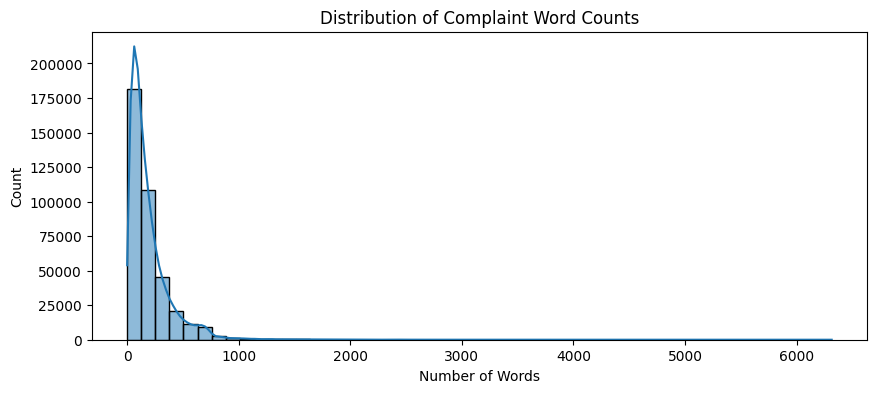

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word count for each complaint
df_cl['word_count'] = df_cl['narrative'].apply(lambda x: len(str(x).split()))

# Display descriptive statistics
print("Word Count Statistics:")
print(df_cl['word_count'].describe())

# Plot distribution of text length
plt.figure(figsize=(10, 4))
sns.histplot(df_cl['word_count'], bins=50, kde=True)
plt.title('Distribution of Complaint Word Counts')
plt.xlabel('Number of Words')
plt.show()

Observations : With describe() we can see a vast majority of complaints are under 300 words.  

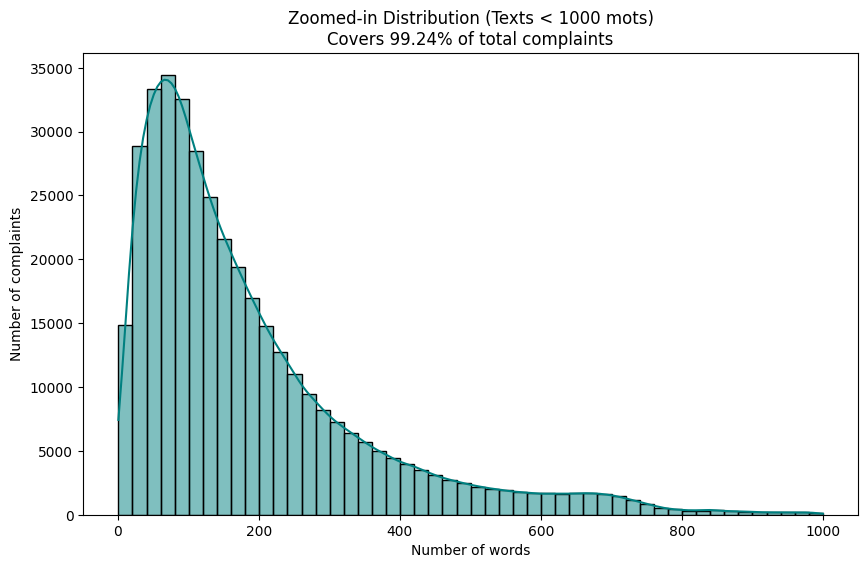

In [9]:
# Filter the dataframe not to show outliers (99% of the complaints are wrtitten with < 1000 words)
zoom_limit = 1000
df_zoom = df_cl[df_cl['word_count'] <= zoom_limit]

# Percentage of the dataframe we've kept
coverage = (len(df_zoom) / len(df_cl)) * 100

plt.figure(figsize=(10, 6))
sns.histplot(df_zoom['word_count'], bins=50, kde=True, color='teal') # 1 bar = 20 words (1000/50)

plt.title(f'Zoomed-in Distribution (Texts < {zoom_limit} mots)\nCovers {coverage:.2f}% of total complaints')
plt.xlabel('Number of words')
plt.ylabel('Number of complaints')
plt.show()

[[105   2   1   4  18  11   3   1   1   8]]


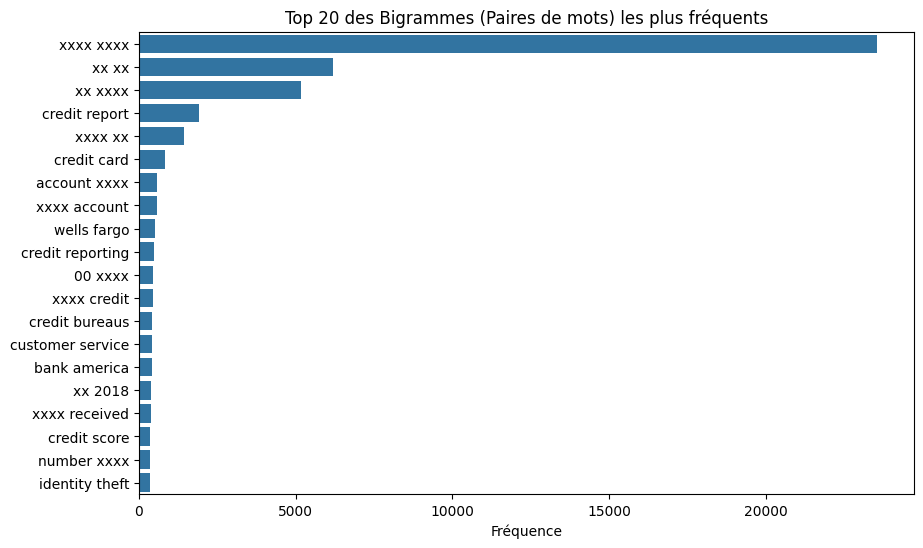

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_bigram(corpus, n=None):

    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus) #create a matrix with complaints for lines, bigrams for columnns
    sum_words = bag_of_words.sum(axis=0) #by summing lines, we obtain #bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 

    # note : vec.vocabulary_  {word:idx} and not {word:#word}

    print(sum_words[:10,:10])
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# little sample for better speed
sample_df = df_cl.sample(10000, random_state=42)

common_words = get_top_n_bigram(sample_df['narrative'], 20)
x, y = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(y), y=list(x))
plt.title('20 most frequent bigrams')
plt.xlabel('Frequence')
plt.show()

Observation: A lot of masked data to be removed before training

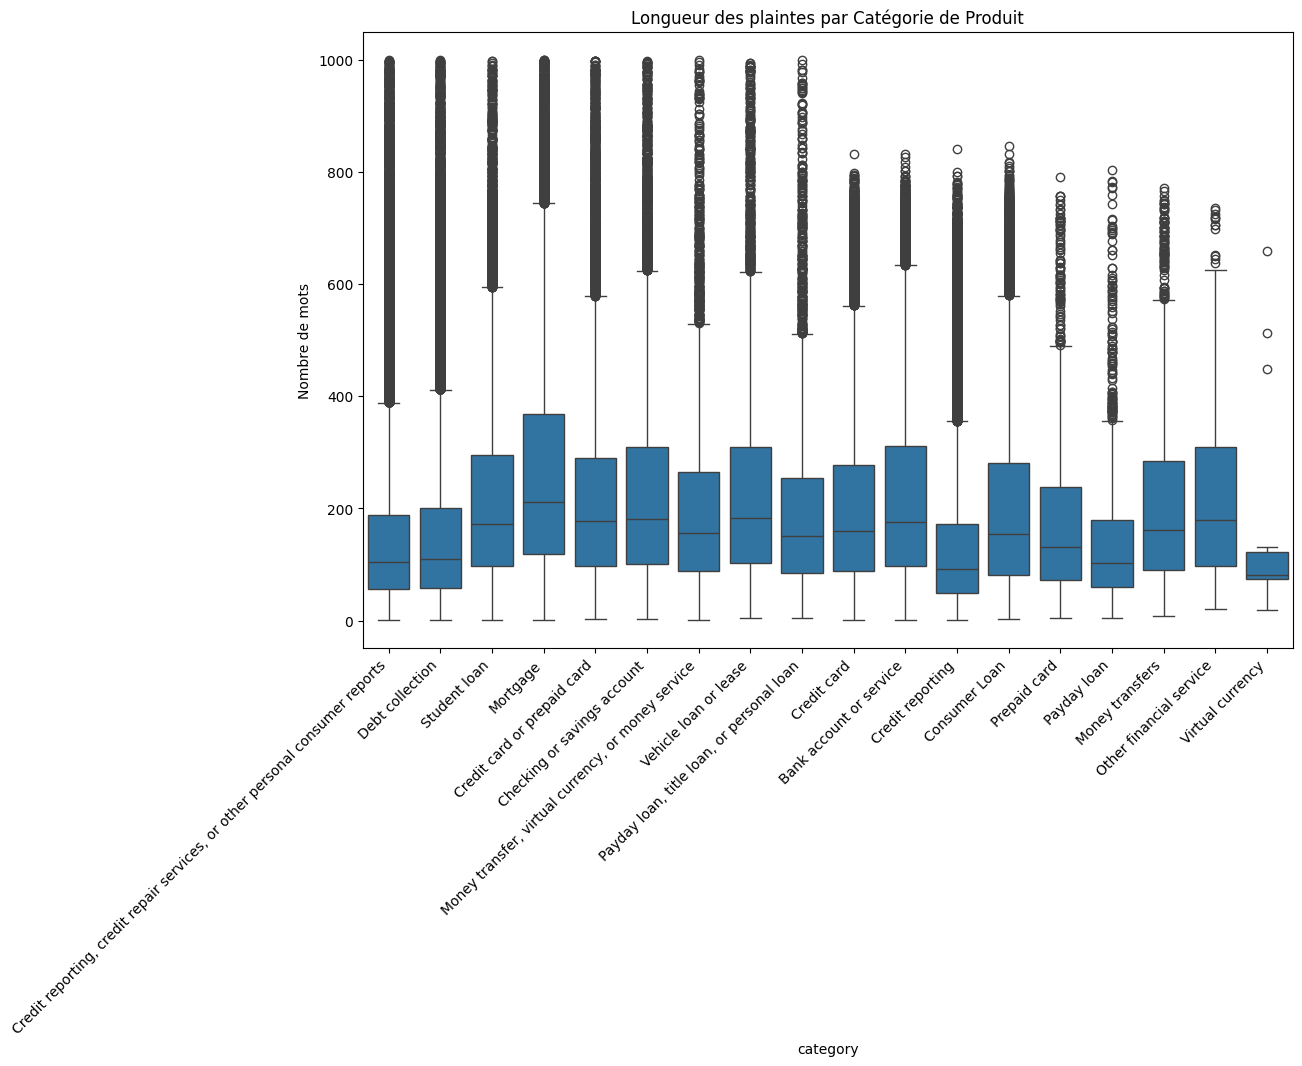

In [ ]:
plt.figure(figsize=(12, 8))

df_zoom = df_cl[df_cl['word_count'] < 1000]

sns.boxplot(x='category', y='word_count', data=df_zoom)
plt.title('Longueur des plaintes par Catégorie de Produit')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Nombre de mots')
plt.show()

Observations: Complaint length varies significantly across product categories, with (more complex?)issues like 'Mortgages' generating longer narratives.